# Analyse SHAP values

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from statkit import decision

/home/WUR/katz001/miniconda3/envs/env_permit_gas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
datasetTimepoint = "PRESURGERY"
target = "Conclusion_micro"
percentBoruta = 100
n_iter = 1000

''' 
Select features
'''
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"    
varPath = f"{PATH}/results/20_featureSelection/{datasetTimepoint}/CV/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

''' 
Define paths
'''
folderFigures = f"{PATH}/figures/{datasetTimepoint}/40_internalValidation"
resultsPath = f"{PATH}/results/40_internalValidation/{datasetTimepoint}/"
dataPath = f"{PATH}/results/10_preprocessed"
dataset = f"{datasetTimepoint}_{target}_preprocessed.csv"

''' 
Split data
'''

with open(f"{PATH}/data/data_dtypes.json", "r") as f:
    dtypes = json.load(f)
data = pd.read_csv(f"{dataPath}/{dataset}", index_col=0, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())

X = data.drop(target, axis=1)
y = data[target]

In [20]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

In [30]:
dic_performanceScores = {
    "acc":np.array([]),
    "prec":np.array([]),
    "recall":np.array([]),
    "brier":np.array([]),
    "roc_auc":np.array([]),
    "pr":np.array([]),
}
for run in range(data.shape[1]):
    predproba = data[run][data[run].notna()]
    pred = predproba.copy()
    pred[predproba < 0.5] = 0
    pred[predproba >= 0.5] = 1
    tru = y.loc[predproba.index]   
    
    ## Accuracy
    dic_performanceScores["acc"] = np.append(dic_performanceScores["acc"],balanced_accuracy_score(tru, pred))
    ## Precision
    dic_performanceScores["prec"] = np.append(dic_performanceScores["prec"],precision_score(tru, pred))
    ## Recall
    dic_performanceScores["recall"] = np.append(dic_performanceScores["recall"],recall_score(tru, pred))
    ## Brier
    dic_performanceScores["brier"] = np.append(dic_performanceScores["brier"],brier_score_loss(tru, predproba))
    ## ROC AUC
    dic_performanceScores["roc_auc"] = np.append(dic_performanceScores["roc_auc"],roc_auc_score(tru, predproba))
    ## PR
    dic_performanceScores["pr"] = np.append(dic_performanceScores["pr"],average_precision_score(tru, predproba))

df_scores = pd.DataFrame.from_dict(dic_performanceScores)

""" 
Calculate confidence intervals 
"""
for col in df_scores.columns:
    print(col, np.mean(df_scores[col]),np.percentile(df_scores[col], 2.5), np.percentile(df_scores[col], 97.5))

acc 0.7258694545536853 0.6416144178109573 0.7964996715208039
prec 0.666226732156364 0.5476190476190477 0.7838861588861588
recall 0.5834482976227723 0.391304347826087 0.7391304347826086
brier 0.15195120391307196 0.12776364134353158 0.18283837017383023
roc_auc 0.8279942629825225 0.7632505948912199 0.8828338279937117
pr 0.6839403707058939 0.5682100061029917 0.7867296874885792


In [29]:
df_scores

,acc,prec,recall,brier,roc_auc,pr
0,0.711310,0.657143,0.547619,0.153915,0.826141,0.653348
1,0.732996,0.596154,0.673913,0.156523,0.815971,0.693394
2,0.717290,0.758621,0.500000,0.145362,0.824554,0.682173
3,0.760000,0.660377,0.700000,0.161974,0.811000,0.681875
4,0.729038,0.727273,0.545455,0.143670,0.845984,0.696184
...,...,...,...,...,...,...
995,0.736406,0.680851,0.627451,0.168258,0.802304,0.699726
996,0.739055,0.738095,0.584906,0.136781,0.877267,0.786828
997,0.664530,0.625000,0.444444,0.149253,0.832051,0.677749
998,0.745789,0.631579,0.631579,0.144399,0.840263,0.607734


# Net benefit

(-0.1, 0.33)

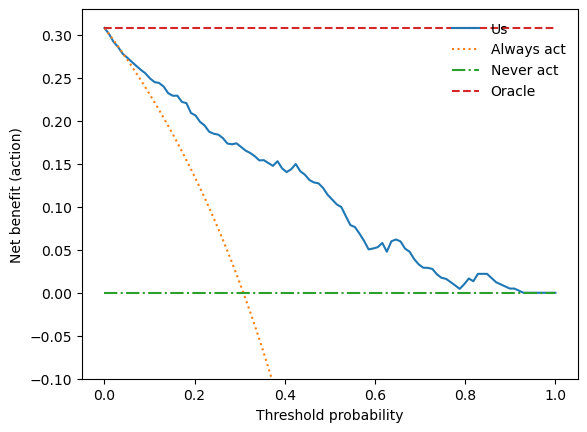

In [31]:
b = data.T.mean().sort_index()
c = y.loc[b.index]

fig, ax = plt.subplots()
decision.NetBenefitDisplay.from_predictions(c, b, name='Us', ax=ax)
ax.set_ylim(0-.1,.33)